<a href="https://colab.research.google.com/github/Ziqi-Li/GEO4162C/blob/spring-24/notebooks/Spatial%20autocorrelation%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spatial Autocorrelation Example

In this example, I will demonstrate how to conduct spatial autocorrelation analysis in python using an example of Georgia's county-level census data.

Specifically, we are mapping the county-level % of people with Bachelor's degree or higher, and conducting global/local moran analysis. Finally, we are able to identify cold spots and hotspots and help us to understand the education inequality in GA.


Install PySAL packages for SA analysis

In [1]:
pip install -q splot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 15.8 MB/s eta 0:00:00


In [2]:
pip install -q libpysal

Load packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot,plot_moran,lisa_cluster
from esda.moran import Moran, Moran_Local
import splot

## Load Georgia dataset

In [4]:
georgia_shp = gpd.read_file("https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/main/data/georgia/G_utm.shp")

First, again check the data we loaded.

In [5]:
georgia_shp.head()

,AREA,PERIMETER,G_UTM_,G_UTM_ID,AREANAME,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,X,Y,AreaKey,geometry
0,9.786480e+08,174967.0,2,1,"GA, Rabun County",34.88129,-83.40143,11648,100.0,11.6,17.18,1.13,13.6,0.35,824645.5,3864805,13241,"POLYGON ((806227.188 3858275.500, 805577.812 3..."
1,4.461530e+08,115140.0,3,2,"GA, Towns County",34.91864,-83.73908,6754,100.0,11.4,22.96,1.36,14.0,0.00,797981.7,3872640,13281,"POLYGON ((779645.188 3875727.750, 808540.188 3..."
2,8.543330e+08,160360.0,4,7,"GA, Union County",34.83436,-83.99088,11993,100.0,10.1,17.55,0.88,18.3,0.10,777040.1,3858779,13291,"POLYGON ((762005.000 3875204.000, 773345.688 3..."
3,1.014270e+09,179577.0,5,4,"GA, Fannin County",34.86415,-84.31928,15992,100.0,7.8,17.30,0.58,17.2,0.03,739255.8,3866604,13111,"POLYGON ((717121.188 3874113.750, 744454.625 3..."
4,8.980900e+08,183295.0,6,3,"GA, Murray County",34.78193,-84.74823,26147,89.0,5.5,7.69,0.50,11.3,0.26,707834.3,3854188,13213,"POLYGON ((699833.188 3873629.500, 703008.812 3..."


<Axes: >

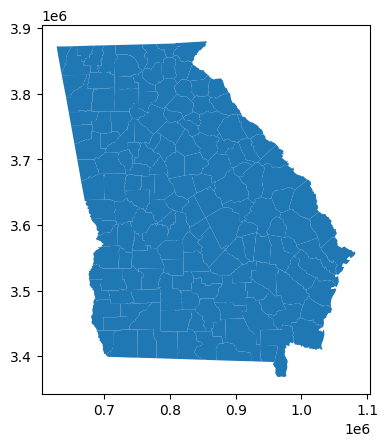

In [6]:
georgia_shp.plot()

The data contains a set of socio-demographic variables. One of them is "PctBach", which is the percentage of population with Bachelor's degree or higher.

Let's make a map this variable. Clearly, we can see that the % Bach is high around Atlanta and Athens.

Text(0.5, 1.0, 'PctBach')

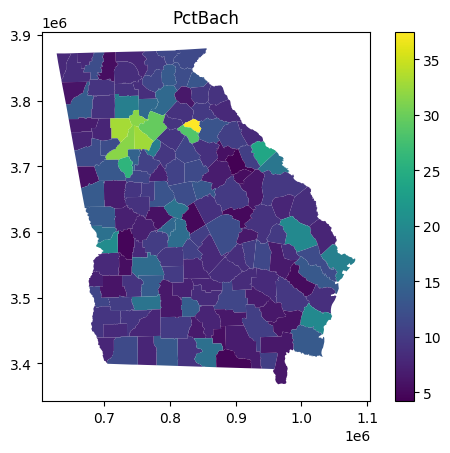

In [7]:
georgia_shp.plot(column="PctBach",legend=True)
plt.title("PctBach")

A map of Georgia for reference
(source:https://www.enchantedlearning.com/usa/states/georgia/map.GIF)


<img src=https://www.enchantedlearning.com/usa/states/georgia/map.GIF width="200" align="left">

## Global Moran's I and p-value

Specify a weight matrix

In [8]:
w = Queen.from_dataframe(georgia_shp) #Generate W matrix using Queen contiguity

w.transform = 'r' #Row-standardization of the weight matrix

('WARNING: ', 65, ' is an island (no neighbors)')


<ipython-input-8-385596cab5f3>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(georgia_shp) #Generate W matrix using Queen contiguity
/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 65.
  warnings.warn(message)


Calculate Moran's I

In [9]:
from esda.moran import Moran

bach = georgia_shp['PctBach'].values #Get the data we are interested.

ga_global_moran = Moran(bach, w, permutations = 200) #200 permutations
ga_global_moran.I

0.2487731738404628

p-value

In [10]:
ga_global_moran.p_sim # P value based on permutation tests

0.004975124378109453

This is indicating a statistically significant (p=0.005<0.05) clustering in the Pct Bach data.


## Moran Scatterplot

/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.25', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.25)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

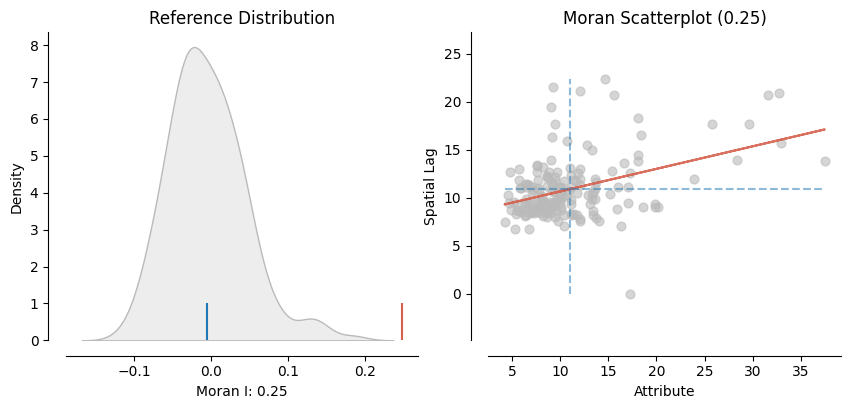

In [11]:
from splot.esda import plot_moran

plot_moran(ga_global_moran, zstandard=False, figsize=(10,4))

The left is the null sampling distribution of Moran's I. The right is the Moran Scatterplot.

Generate a better Moran Scatterplot with significance of the local moran's Is.

Color code each county with the quadrant it falls into.
- Red: HH (High values near high values)
- Light Blue: LH
- Yellow: HL
- Blue: LL

/usr/local/lib/python3.10/dist-packages/esda/moran.py:1059: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Text(0, 0.5, 'Spatial Lag of Pct Bach')

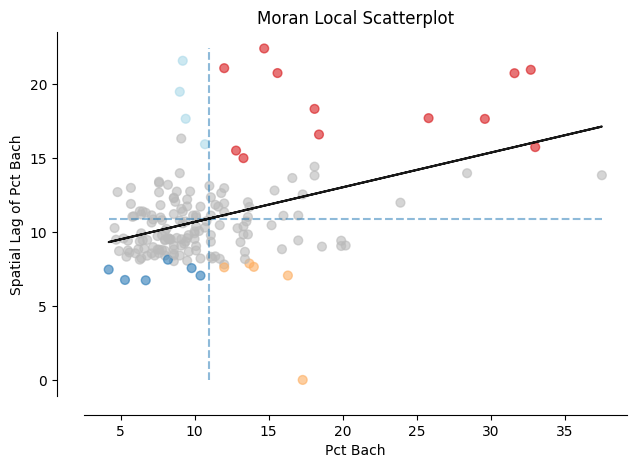

In [12]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
ga_moran_loc = Moran_Local(bach, w,permutations=200)

fig, ax = moran_scatterplot(ga_moran_loc, zstandard=False, p=0.05)

#Labelling
ax.set_xlabel('Pct Bach')
ax.set_ylabel('Spatial Lag of Pct Bach')


Create a hot-spot and cold-spot map.
- HH: High % Bach county surrounded by High % Bach county
- LL: Low-Low
- LH: Low-High
- HL: High-Low
- NS: Non-significant (p>0.05)

(<Figure size 600x600 with 1 Axes>, <Axes: >)

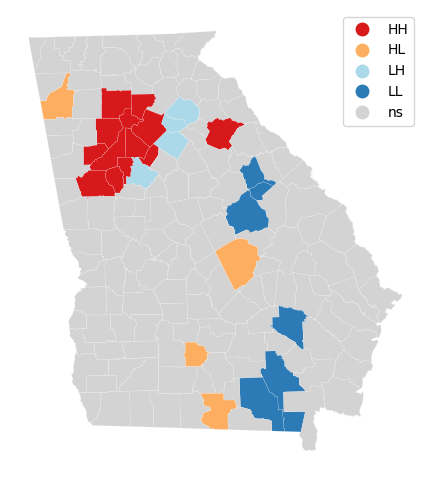

In [13]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc=ga_moran_loc, gdf=georgia_shp, p = 0.05, figsize = (6,6))

We can see a statistically significant hotspot cluster close to Atlanta.